## IMAGE COLORIZR Project SS20
#####  Trattnig Sebastian, Daniel Leustik

### Convert gray-scaled photos to colored photos
##### Data Preparation:

First Version - only 8 pics of size 256x256,
Downloaded pictures from a "floydhub" dataset,
Second Version - downloaded pics of different size,
Phyton script for resizing images to 256x256,
Manually filtered out images which are stretched too much

##### Approach: 

use keras, 
collect data, 
build sequential model, 
train, 
convert (test)  

In [28]:
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint

from skimage.color import rgb2lab, lab2rgb, rgb2gray
from IPython.display import display
import matplotlib.pyplot as plt
from skimage.io import imsave
import tensorflow as tf
from PIL import Image
import numpy as np
import random
import shutil
import PIL
import os

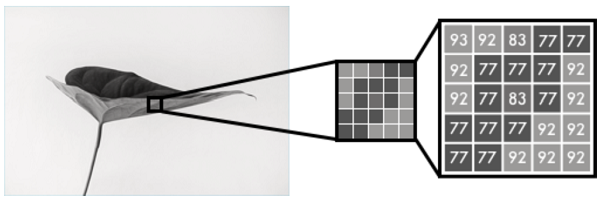

In [36]:
## Core logic

display(Image.open('images/6.png'))

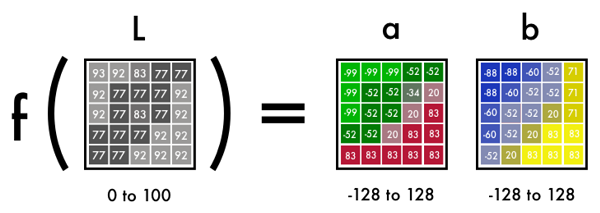

In [37]:
display(Image.open('images/5.png'))

In [26]:
# collect data - filling an array with images using a loop

data = []
for filename in os.listdir('images/Images_version_1/Train/'):
    data.append(img_to_array(load_img('images/Images_version_1/Train/'+filename)))
    print(filename)

# convert image array to float array of images
data = np.array(data, dtype=float)

# set up train data - consider RGB value 255
Xtrain = data
Xtrain = 1.0/255*Xtrain

00_oTQFRtzo.jpg
1PFDZe.jpg
8X0jDX.jpg
img_1.jpg
_1PQZwx4kEM.jpg
_6e5zZx8dHg.jpg
_TedQjjFnX8.jpg
_z8isp4cTfI.jpg


## Build neural network
### by using Sequential model (keras) - deep learning 

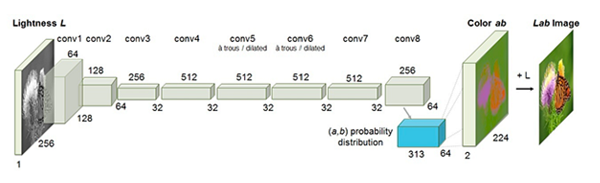

In [38]:
display(Image.open('images/2.png'))

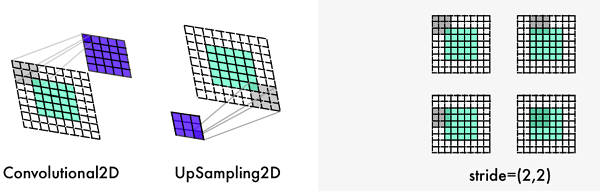

In [39]:
display(Image.open('images/3.png'))

In [40]:
model = Sequential()
# define an input layer (only once) - input data have shape of 256x256
# be aware that convolutional takes a 3D input so we need to shape to 256x256 and 1 for 1 color space
# specifing input shape sets also the weight for our model

# 1st filter, 2st kernel space (3,3) <-- size of filter
# activation relu -- good for deep learning (tangente)
# padding - output from kernel will decrease - padding does that it will fill up cells with 0's
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 1)))
# strides -> nr or tuple - how much kernel should be moved (2 px)
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='rmsprop', loss='mse' , metrics=["accuracy"])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 256, 256, 64)      640       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 512)      

In [ ]:
# Setup ImageDataGenerator
# How does it work?
#    1) accepting batch of images
#    2) apply random transformation to each image
#    3) replace original batch we newly transformed batch
#    4) train CNN on newly transformed batch

dataGenerator = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2
)

# define batch size
batch_size = 10

In [ ]:
# define function to call ImagedataGenerator
def imageGenerator(batch_size):
    for batch in dataGenerator.flow(Xtrain, batch_size=batch_size):
        # be aware that we have rgb colored photos, to work better we 
        # call rgb2lab function which converts image to a lab image with a b color channel
        # # Lab color, L -> grayscale layer, a b -> color layers (green-red, blue-yellow)
        lab_of_batch = rgb2lab(batch)
        # extract b/w layer for Xbatch
        Xbatch = lab_of_batch[:,:,:,0] # [:,:,:,0] -> select grayscale layer
        # extract two color layer for Ybatch
        # ab spectrum [-128,128] .. divide by 128 to get [-1,1]
        Ybatch = lab_of_batch[:,:,:,1:]/128 # [:,:,:,1:] -> select color layer
        # return generator object
        yield(Xbatch.reshape(Xbatch.shape+(1,)), Ybatch)

# Train & checkpointing
filepath = "model_1409_test.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [42]:
# keras support 3 types of training
#   1.fit, 2. fit_generator, 3. train_on_batch

# to train on large models .fit would not be suitable because RAM overfilled

# .fit_generator - here data is no longer “static” — the data is constantly changing
# Each new batch of data is randomly adjusted according to the parameters supplied to ImageDataGenerator
# .fit_generator accepts the batch of data, performs backpropagation, and updates the weights in our model

# .train_on_batch -- fine-grained control over training your deep learning models - mostly not suitable

#steps per epoch = number of images / batch size

history = model.fit_generator(imageGenerator(batch_size), epochs=10, steps_per_epoch=10, verbose=1, callbacks=callbacks_list)

Epoch 1/10
10/10 [==============================] - 59s 6s/step - loss: 2.0355e-04 - accuracy: 0.9133
Epoch 2/10
10/10 [==============================] - 58s 6s/step - loss: 2.2020e-04 - accuracy: 0.9223
Epoch 3/10
10/10 [==============================] - 58s 6s/step - loss: 2.1675e-04 - accuracy: 0.9243
Epoch 4/10
10/10 [==============================] - 56s 6s/step - loss: 3.3243e-04 - accuracy: 0.9147
Epoch 5/10
10/10 [==============================] - 55s 5s/step - loss: 2.0177e-04 - accuracy: 0.9159
Epoch 6/10
10/10 [==============================] - 53s 5s/step - loss: 2.2223e-04 - accuracy: 0.9187
Epoch 7/10
10/10 [==============================] - 55s 6s/step - loss: 5.2761e-04 - accuracy: 0.8933
Epoch 8/10
10/10 [==============================] - 55s 5s/step - loss: 4.0264e-04 - accuracy: 0.9045
Epoch 9/10
10/10 [==============================] - 52s 5s/step - loss: 2.0699e-04 - accuracy: 0.9219
Epoch 10/10
10/10 [==============================] - 54s 5s/step - loss: 2.2151e-0

### Why does training lasts so loooong?

In [43]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


#### It is always good to keep an eye of the history

dict_keys(['loss', 'accuracy'])


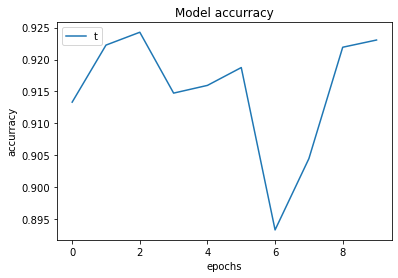

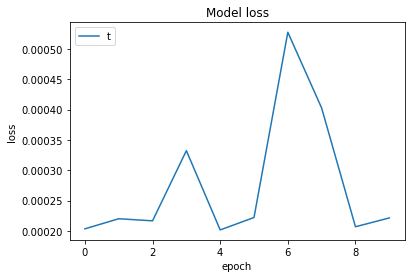

In [44]:
# List all data in history object
print(history.history.keys())

# print accurarcy model with plot
plt.plot(history.history['accuracy'])
plt.title('Model accurracy')
plt.ylabel('accurracy')
plt.xlabel('epochs')
plt.legend('train')
plt.show()

# print history for loss
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend('train', loc='upper left')
plt.show()

np.save('history_1409_test.npy', history.history)

In [45]:
# Save model
model_json = model.to_json()
with open("model_14_09.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_14_09.h5")

In [46]:
# load json and create model

from keras.models import model_from_json
json_file = open('model_14_09.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_14_09.h5")

### Test images

In [47]:
# Colorizer section 
images_to_color = []
for filename in os.listdir('images/Images_version_1/Test/'):
    images_to_color.append(img_to_array(load_img('images/Images_version_1/Test/'+filename)))

# convert color space, reshape img
images_to_color = np.array(images_to_color, dtype=float)
images_to_color = rgb2lab(1.0/255*images_to_color)[:,:,:,0]
images_to_color = images_to_color.reshape(images_to_color.shape+(1,))

# Test model with predict() function
output = model.predict(images_to_color)

# covert color value back from [-1,1] to [-128,128] which is Lab color spectrum
output = output * 128

# Output colorizations
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))            # make empty 256x256 with 3 layers
    cur[:,:,0] = images_to_color[i][:,:,0]   # copy grayscale layer to new obj
    cur[:,:,1:] = output[i]                  # copy color layer to new obj
    # save img in directory
    imsave("images/Images_version_1/Result/img_"+str(i)+".png", lab2rgb(cur))


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

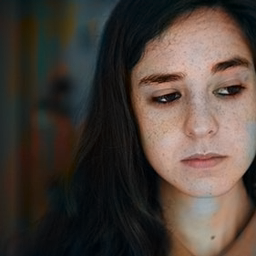

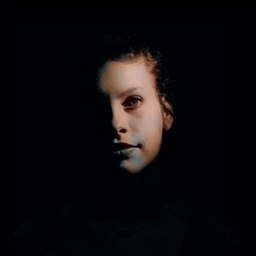

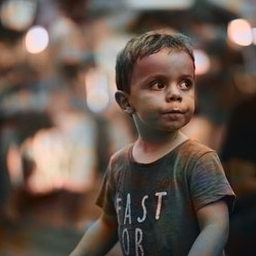

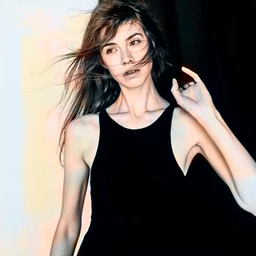

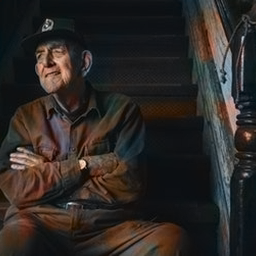

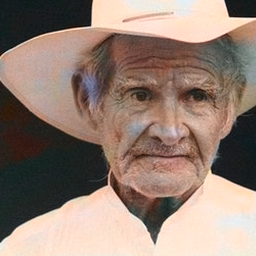

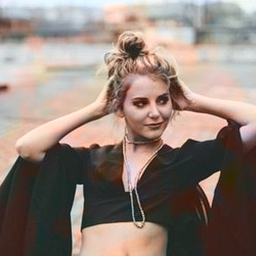

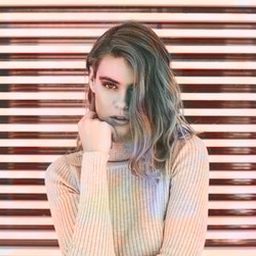

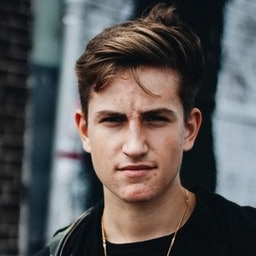

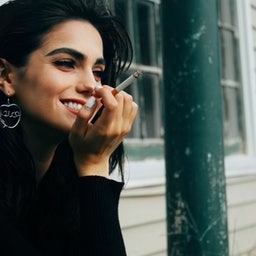

In [41]:
images_to_color = []

for filename in os.listdir('images/Images_version_1/Result/'):
    path='images/Images_version_1/Result/'+filename
    display(Image.open(path))